In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
import theano.tensor as tt

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We will use probabilistic programming to analyze a population survey that was taken by several thousand household mothers living in Rwanda in 2015.  

Specifically, we will try to find the probability that a mother wants her last pregnancy, given the total amount of children she had given birth to.

In [90]:
fields = ['m10_1', 'v201']
df = pd.read_stata('RWIR70FL.DTA', columns=fields)

In [91]:
df.dropna(subset=['m10_1'], inplace=True)
df.m10_1.replace({'then':0, 'later':6, 'no more':1}, inplace=True)

# drop mothers that wanted pregnancy 'later' since it is no longer a matter of want or not want children, but rather
# a question of time. With the remaining two survey reponses ('then' & 'no-more'), one can conclude without doubt whether
# there WAS or was NOT a desire to have more children

df = df[df.m10_1<6]

In [92]:
print("Wanted pregnancy when became pregnant: \nThen/Later=0\nNo More=1")
print(df.m10_1.value_counts())
print("Total children ever born to mother")
print(df.v201.value_counts())

Wanted pregnancy when became pregnant: 
Then/Later=0
No More=1
0    3591
1     775
Name: m10_1, dtype: int64
Total children ever born to mother
1     1151
2      982
3      653
4      517
5      358
6      271
7      205
8      113
9       70
10      25
11      15
12       5
13       1
Name: v201, dtype: int64


In [93]:
print("Correlation between wanting pregnancy and number of children")
df.m10_1.corr(df.v201)

Correlation between wanting pregnancy and number of children


0.43392109535224654

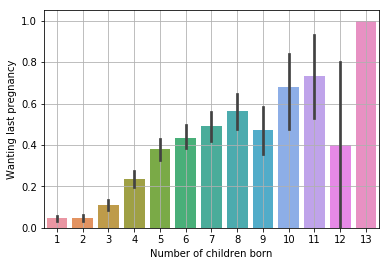

In [94]:
sns.barplot(df.v201, df.m10_1)
plt.ylabel("Wanting last pregnancy")
plt.xlabel("Number of children born")
plt.grid()
plt.show()

# Probabiliy of wanting last pregnancy

In [95]:
children_born = np.array(df.v201) # Total children born
want_pregnancy = np.array(df.m10_1)  # Wanted last pregnancy (0) or not (1)?

with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.01, testval=0) # when τ=0.01, the variance is 1/τ, which is 100 
    alpha = pm.Normal("alpha", mu=0, tau=0.01, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*children_born + alpha)))
    #p = pm.Deterministic("p", pm.math.sigmoid((-1)*beta*children_born + alpha*(-1))) # sigmoid is more stable

In [96]:
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=want_pregnancy)
    trace = pm.sample(3000, tune=1000, njobs=1)
    burned_trace = trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta]
100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:05<00:00, 61.21it/s]


In [97]:
pm.summary(burned_trace, varnames=['alpha','beta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,3.411140,0.094231,0.002864,3.221797,3.587011,1073.249163,1.001093
beta,-0.484755,0.019450,0.000581,-0.523952,-0.448805,1048.710332,1.000742


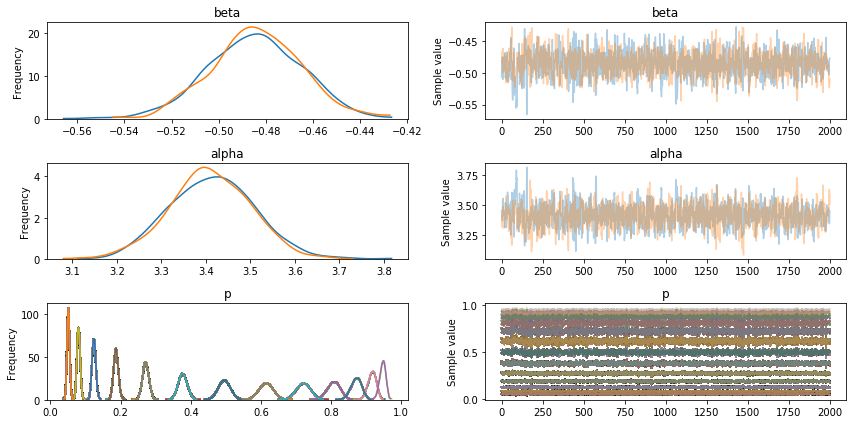

In [98]:
pm.traceplot(burned_trace)
plt.show()

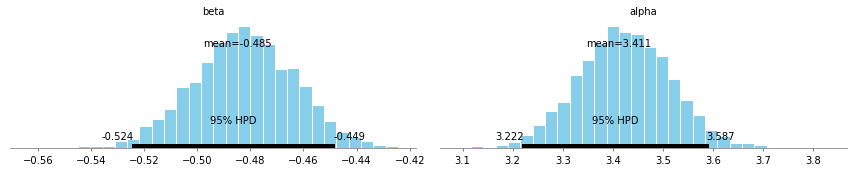

In [99]:
pm.plot_posterior(burned_trace,
                  varnames=['beta','alpha'], 
                  color='#87ceeb')
plt.show()

In [100]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha)) #same as (1.0/(1. + tt.exp(beta*temperature + alpha)))

t = np.linspace(children_born.min() - 0.5, children_born.max()+0.5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

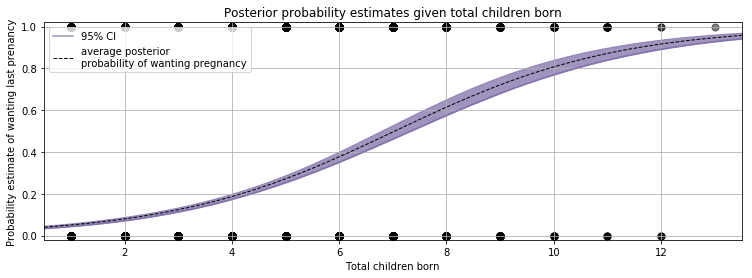

In [101]:
from scipy.stats.mstats import mquantiles

plt.figure(figsize=(12.5, 4))

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of wanting pregnancy")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="upper left")
plt.scatter(children_born, want_pregnancy, color="k", s=50, alpha=0.5)
plt.xlabel("Total children born")

plt.ylabel("Probability estimate of wanting last prenancy")
plt.title("Posterior probability estimates given total children born")
plt.grid()
plt.show()

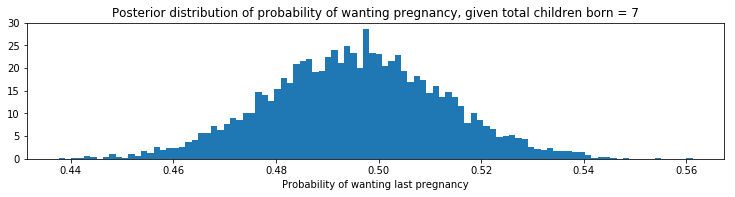

In [104]:
plt.figure(figsize=(12.5, 2.5))

prob_7 = logistic(7, beta_samples, alpha_samples)

plt.hist(prob_7, bins=100, normed=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of wanting pregnancy, given total children born = 7")
plt.xlabel("Probability of wanting last pregnancy");

There is around 50% chance that a woman would NOT want her last pregnancy if she had 7 children.